<a href="https://colab.research.google.com/github/mhuertascompany/DL_ED127_2020/blob/master/tutorials/day5/VAE_SDSS_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE FOR GALAXY SDSS SPECTRA

The goal of this tutorial is to see if VAEs are able to caputre the different galaxy types (e.g. star-forming, passive, AGNs..) from the unsupervised decomposition of spectra. See [Portillo+18](https://ui.adsabs.harvard.edu/abs/2020arXiv200210464P/abstract)
---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---





## Import packages


In [2]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pdb
import pickle
from astropy.io import fits
from astropy.visualization.stretch import SqrtStretch
from astropy.visualization import ImageNormalize, MinMaxInterval

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



Mount your drive into Colab:

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then load the data for training. The dataset (X) contains 2 numpy arrays with the galaxy images (128*128 pixels) and the known effective radii for every galaxy. For the training we are using Single Sersic Models convolved with an HST PSF and with real HST noise added. The effective size of the modeled galaxies is thus known and stored in vector Y. The goal is to estimate Y from X.

In [0]:
#Load data
pathinData="/content/drive/My Drive/EDE2019/spectra"

#images
spectra = np.load(pathinData+'/flux.npy')

#wavelength

wl = np.load(pathinData+'/wl.npy')

#labels
label = np.load(pathinData+'/bpt_labels.npy') 


## Visualize Spectra

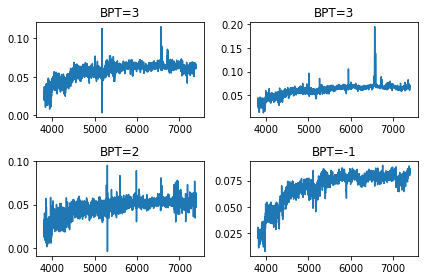

In [14]:
stretch = SqrtStretch() 

randomized_inds_train = np.random.permutation(len(spectra))


fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  plt.plot(wl,spectra[i,:])
  #im = ax.imshow(x_train[i,:,:,0], origin='lower', cmap='gray',
    #vmin=vmin, norm=norm,vmax=vmax)
  plt.title('BPT='+str(label[i]))
  fig.tight_layout() 
  #fig.colorbar(im)


## Model Setup

Your goal is to setup a VAE that takes as input the spectra we plotted above and learns to generate them. Then you can plot the embeded space and see if things do cluster. Feel free to try differnt approaches!

## Plotting the results
Plot here the results of your embeddings